In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to suppress tf warnings

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import load_model
import IPython.display
from matplotlib import pyplot as plt
import joblib
from utils import *

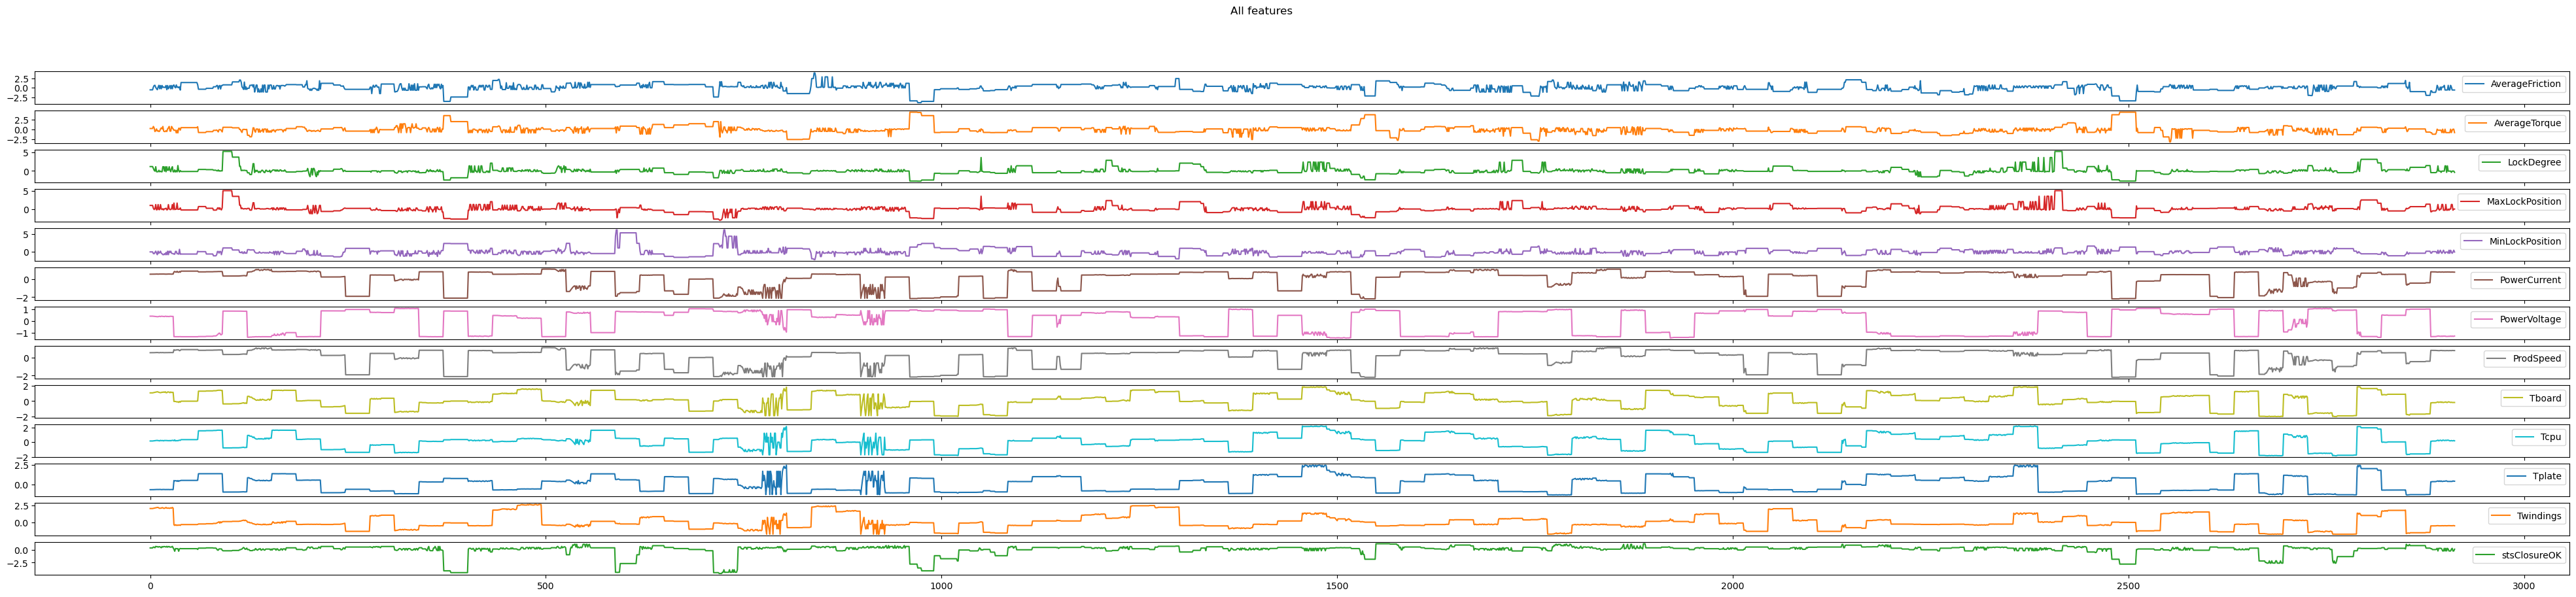

In [2]:
# Load the dataset
df = pd.read_csv("data/dataframe_interpolated_augmented.csv") # Load the dataframe
df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'sensor_time'], inplace=True) # Drop useless columns ("Unnamed" is created by pandas when saving the dataframe to a csv file)
column_indices = {name: i for i, name in enumerate(df.columns)} # Create a dictionary of column indices
n = len(df)
scalers = {} # Create a dictionary of scalers
num_features = df.shape[1]

# Calculate normalization parameters
for column in df.columns: # Loop through all the columns
    scaler = StandardScaler() # Create a scaler
    df[column] = scaler.fit_transform(df[[column]]) # Normalize the data
    scalers[column] = scaler # Save the scaler

# Save the scalers
joblib.dump(scalers, 'data/scalers.pkl')
df.drop(index=0, inplace=True)

# Split the data into training, validation and test sets, we use 70% of the data for training, 20% for validation and 10% for testing
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
plot_features = df
plot_features.index = range(df.shape[0])

_ = plot_features.plot(subplots=True,figsize=(50, 10), title='All features')

In [3]:
print(df.shape)

(2913, 13)


In [4]:
MAX_EPOCHS = 100 # Maximum number of epochs
LEARNING_RATE = 0.001 # Starting Learning rate
MIN_LEARNING_RATE = 1e-6 # Minimum learning rate (it is decreased by the ReduceLROnPlateau callback if the validation loss does not decrease for a certain number of epochs)
OUT_STEPS = 24 # Number of output steps for multi-step model

performance = {} # Dictionary to store the performance of the models
val_performance = {} # Dictionary to store the validation performance of the models

def compile_and_fit(model, window, patience=10):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', # Stop training when the validation loss no longer decreases (or increases)
                                                    patience=patience,
                                                    mode='min', verbose=1)
  
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=patience/2, min_lr=MIN_LEARNING_RATE) # Reduce the learning rate if the validation loss does not decrease for a certain number of epochs
  
  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.MeanAbsoluteError()])
  
  history = model.fit(window.train, epochs=MAX_EPOCHS, # Train the model
                      validation_data=window.val,
                      callbacks=[early_stopping,reduce_lr])

  return history

138/138 [==============================] - 0s 828us/step - loss: 0.1700 - mean_absolute_error: 0.2099

CPU times: user 830 ms, sys: 118 ms, total: 948 ms
Wall time: 903 ms


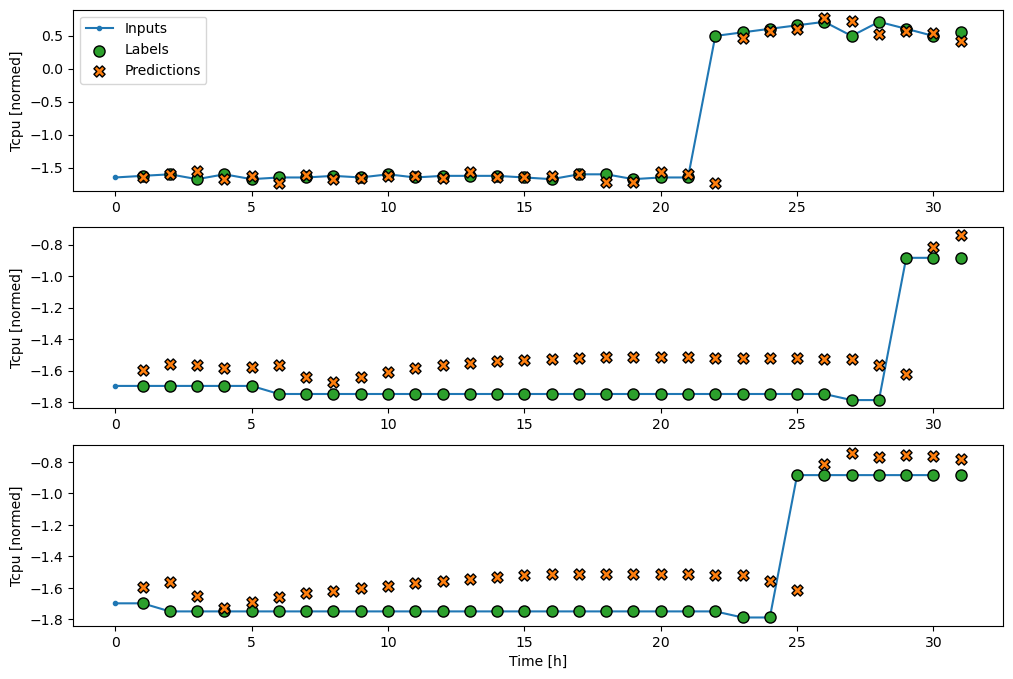

In [5]:
%%time
wide_window = WindowGenerator(
    input_width=31, label_width=31, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

# history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()

lstm_model = load_model('models/lstm_model.keras')

val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)
wide_window.plot(lstm_model)
lstm_model.save('models/lstm_model.keras')

print()

In [6]:
@keras.saving.register_keras_serializable()
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        return inputs + delta

In [7]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

# history = compile_and_fit(residual_lstm, wide_window)

residual_lstm = load_model('models/residual_lstm')

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test)
residual_lstm.save('models/residual_lstm', save_format='tf')
print()

65/65 [==============================] - 0s 807us/step - loss: 0.1957 - mean_absolute_error: 0.2413


INFO:tensorflow:Assets written to: models/residual_lstm/assets


INFO:tensorflow:Assets written to: models/residual_lstm/assets



CPU times: user 2.52 s, sys: 163 ms, total: 2.68 s
Wall time: 2.34 s


LSTM           : 0.2518
Residual LSTM  : 0.2413


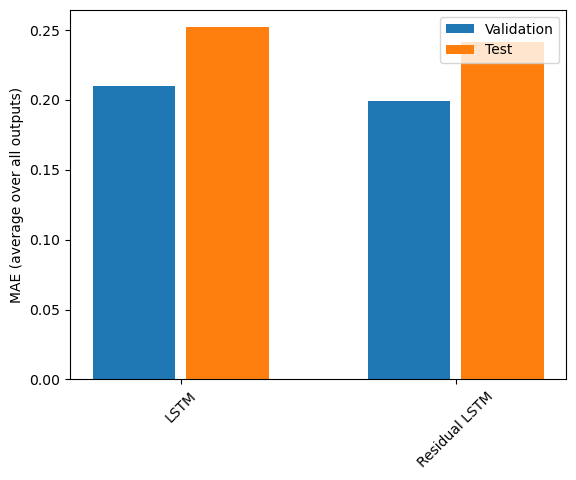

In [8]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')